# Non-Gaussian Likelihoods

## Introduction

This example is the simplest form of using an RBF kernel in an `ApproximateQEP` module for classification. This basic model is usable when there is not much training data and no advanced techniques are required.

In this example, we’re modeling a unit wave with period 1/2 centered with positive values @ x=0. We are going to classify the points as either +1 or -1.

Variational inference uses the assumption that the posterior distribution factors multiplicatively over the input variables. This makes approximating the distribution via the KL divergence possible to obtain a fast approximation to the posterior. For a good explanation of variational techniques, sections 4-6 of the following may be useful: https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf

In [1]:
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 10 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels. Labels are unit wave with period 1/2 centered with positive values @ x=0.

In [2]:
train_x = torch.linspace(0, 1, 10)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi))).add(1).div(2)

## Setting up the classification model

The next cell demonstrates the simplest way to define a classification Gaussian process model in QPyTorch. If you have already done the [QEP regression tutorial](../01_Exact_QEPs/Simple_QEP_Regression.ipynb), you have already seen how QPyTorch model construction differs from other QEP packages. In particular, the QEP model expects a user to write out a `forward` method in a way analogous to PyTorch models. This gives the user the most possible flexibility.

Since exact inference is intractable for QEP classification, QPyTorch approximates the classification posterior using **variational inference.** We believe that variational inference is ideal for a number of reasons. Firstly, variational inference commonly relies on gradient descent techniques, which take full advantage of PyTorch's autograd. This reduces the amount of code needed to develop complex variational models. Additionally, variational inference can be performed with stochastic gradient decent, which can be extremely scalable for large datasets.

If you are unfamiliar with variational inference, we recommend the following resources:
- [Variational Inference: A Review for Statisticians](https://arxiv.org/abs/1601.00670) by David M. Blei, Alp Kucukelbir, Jon D. McAuliffe.
- [Scalable Variational Gaussian Process Classification](https://arxiv.org/abs/1411.2005) by James Hensman, Alex Matthews, Zoubin Ghahramani.
  
In this example, we're using an `UnwhitenedVariationalStrategy` because we are using the training data as inducing points. In general, you'll probably want to use the standard `VariationalStrategy` class for improved optimization.

In [3]:
from qpytorch.models import ApproximateQEP
from qpytorch.variational import CholeskyVariationalDistribution
from qpytorch.variational import UnwhitenedVariationalStrategy
POWER = 1.0

class QEPClassificationModel(ApproximateQEP):
    def __init__(self, train_x):
        self.power = torch.tensor(POWER)
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0), power=self.power)
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(QEPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = qpytorch.kernels.ScaleKernel(qpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)
        return latent_pred


# Initialize model and likelihood
model = QEPClassificationModel(train_x)
likelihood = qpytorch.likelihoods.BernoulliLikelihood()

### Model modes

Like most PyTorch modules, the `ApproximateGP` has a `.train()` and `.eval()` mode.
- `.train()` mode is for optimizing variational parameters model hyperameters.
- `.eval()` mode is for computing predictions through the model posterior.

## Learn the variational parameters (and other hyperparameters)

In the next cell, we optimize the variational parameters of our q-exponential process.
In addition, this optimization loop also performs Type-II MLE to train the hyperparameters of the q-exponential process.

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for QEPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = qpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 0.482
Iter 2/100 - Loss: 1.555
Iter 3/100 - Loss: 0.807
Iter 4/100 - Loss: 0.801
Iter 5/100 - Loss: 0.823
Iter 6/100 - Loss: 0.729
Iter 7/100 - Loss: 0.636
Iter 8/100 - Loss: 0.606
Iter 9/100 - Loss: 0.614
Iter 10/100 - Loss: 0.613
Iter 11/100 - Loss: 0.601
Iter 12/100 - Loss: 0.587
Iter 13/100 - Loss: 0.572
Iter 14/100 - Loss: 0.554
Iter 15/100 - Loss: 0.532
Iter 16/100 - Loss: 0.509
Iter 17/100 - Loss: 0.491
Iter 18/100 - Loss: 0.480
Iter 19/100 - Loss: 0.473
Iter 20/100 - Loss: 0.470
Iter 21/100 - Loss: 0.467
Iter 22/100 - Loss: 0.464
Iter 23/100 - Loss: 0.460
Iter 24/100 - Loss: 0.457
Iter 25/100 - Loss: 0.454
Iter 26/100 - Loss: 0.451
Iter 27/100 - Loss: 0.449
Iter 28/100 - Loss: 0.447
Iter 29/100 - Loss: 0.446
Iter 30/100 - Loss: 0.445
Iter 31/100 - Loss: 0.445
Iter 32/100 - Loss: 0.444
Iter 33/100 - Loss: 0.444
Iter 34/100 - Loss: 0.443
Iter 35/100 - Loss: 0.442
Iter 36/100 - Loss: 0.442
Iter 37/100 - Loss: 0.441
Iter 38/100 - Loss: 0.440
Iter 39/100 - Loss: 0

## Make predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

In `.eval()` mode, when we call `model()` - we get QEP's latent posterior predictions. These will be MultivariateQExponential distributions. But since we are performing binary classification, we want to transform these outputs to classification probabilities using our likelihood.

When we call `likelihood(model())`, we get a `torch.distributions.Bernoulli` distribution, which represents our posterior probability that the data points belong to the positive class.

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_samples = f_preds.sample(sample_shape=torch.Size((1000,))
```

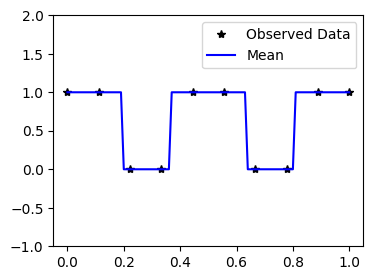

In [7]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean'])

## Notes on other Non-Gaussian Likeihoods

The Bernoulli likelihood is special in that we can compute the analytic (approximate) posterior predictive in closed form. That is: $q(\mathbf y) = E_{q(\mathbf f)}[ p(y \mid \mathbf f) ]$ is a Bernoulli distribution when $q(\mathbf f)$ is a multivariate Gaussian.

Most other non-Gaussian likelihoods do not admit an analytic (approximate) posterior predictive. To that end, calling `likelihood(model)` will generally return Monte Carlo samples from the posterior predictive.

In [8]:
# Analytic marginal
likelihood = qpytorch.likelihoods.BernoulliLikelihood()
observed_pred = likelihood(model(test_x))
print(
    f"Type of output: {observed_pred.__class__.__name__}\n"
    f"Shape of output: {observed_pred.batch_shape + observed_pred.event_shape}"
)

Type of output: Bernoulli
Shape of output: torch.Size([101])


In [9]:
# Monte Carlo marginal
likelihood = qpytorch.likelihoods.BetaLikelihood()
with qpytorch.settings.num_likelihood_samples(15):
    observed_pred = likelihood(model(test_x))
print(
    f"Type of output: {observed_pred.__class__.__name__}\n"
    f"Shape of output: {observed_pred.batch_shape + observed_pred.event_shape}"
)
# There are 15 MC samples for each test datapoint

Type of output: Beta
Shape of output: torch.Size([15, 101])


See [the Likelihood documentation](https://qepytorch.readthedocs.io/en/stable/likelihoods.html#likelihood) for more details.